## 4.基于逻辑回归分类算法的信用卡欺诈检测

**1.读取数据，分析数据**

导入工具包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings#导入warning模块
warnings.filterwarnings('ignore')#忽略所有警告信息
%matplotlib inline 

读取数据

In [2]:
data = pd.read_csv('data/data_creditcard.csv',encoding='gbk')
data

,时间,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,交易金额,类别
0,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
1,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
2,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
4,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284792,172782.0,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49,0
284793,172782.0,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,24.05,0
284794,172783.0,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,79.99,0
284795,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0


上述数据解释：特征1-特征28是已经处理好的特征数据，原始数据为个人交易记录，但考虑到数据本身的隐私性，对原数据进行了处理。<br/>
观察表格可以发现数据有两个问题：1.“时间”这一列对本案例没有意义；2.“交易金额”这一列数值波动太大，会导致后续权重分配不均匀。<br/>
<br/>
观察正常、异常 数据量：对“类别”列的数据分类（0、1类）、技术，并绘制柱状图来展现0、1的分布情况

Text(0, 0.5, 'Frequency')

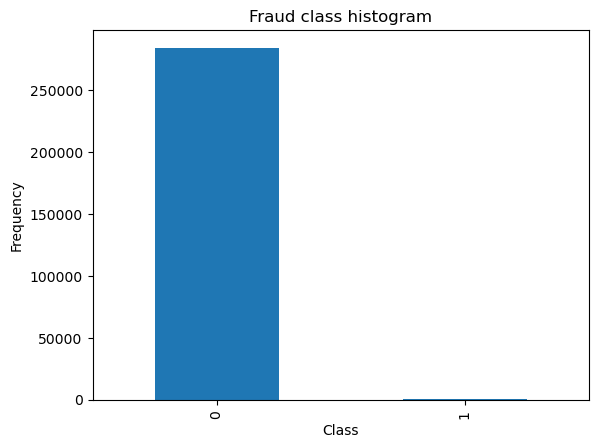

In [3]:
count_classes = pd.value_counts(data['类别'],sort=True)#先通过pandas中的value_counts函数计算“类别”列中0,1各有多少个。
#value_count()查看表格某列中的有几种不同值，并计算每种不同值在该列有多少重复值。
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

上述结果解释：观察柱状图，class=0的数据大概有28w，class=1的数据只有500，数据极度不均衡，要进行数据均衡处理，有两种方法：1、下采样（让0和1一样少，从0中选出500个）2、过采样（让1和0一样多，以原始数据集为依据，创造新的样本）。

**2.数据预处理**

**2.1.标准化数据**

In [4]:
#导入sklearn中预处理的标准化模块
from sklearn.preprocessing import StandardScaler

#对“交易金额”列标准化，得到新列“标准交易金额”
data['标准化交易金额'] = StandardScaler().fit_transform(data['交易金额'].values.reshape(-1, 1))
#fit_transform：fit计算参数μ、o，transform标准化：(x-μ)/0。
#.values：API文档要求转换成array格式；.reshape(-1,1)：API文档要求二维

**2.2.删除无关列**

In [5]:
#删除数据集中的不相关列
data = data.drop(['时间','交易金额'],axis=1)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,类别,标准化交易金额
0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.338549
1,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0,-0.333272
2,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0,-0.190103
3,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0,0.019394
4,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0,-0.338509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284792,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,0,-0.331273
284793,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0,-0.257070
284794,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0,-0.033420
284795,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,0,-0.342508


**3.用下采样方案训练模型**

**3.1.建立下采样训练集、测试集**

建立下采样数据集

In [6]:
X = data.iloc[:, data.columns != '类别']#取特征（列名不是“类别”的所有数据）
y = data.iloc[:, data.columns == '类别']#取标签（列名是“类别”的数据）

#筛选出类别=1的数据（异常样本），取其索引
number_records_fraud = len(data[data.类别 == 1])#统计数据集中类别=1（异常样本）的数据数量
fraud_indices = np.array(data[data.类别 == 1].index)#将类别=1的数据索引转化成为np.array类型的数组（矩阵）

#筛选出类别=0的数据（正常样本），取其索引
normal_indices = data[data.类别 == 0].index 

#从正常样本的索引中随机选择和异常样本相同数量的索引，并转化为np.array
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
                                                                              #replace = False：输出数字不可重复
random_normal_indices = np.array(random_normal_indices)

#将异常样本索引和随机选择的正常样本索引粘合在一起，构成新数据集的索引
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

#根据索引，得到下采样数据集
under_sample_data = data.iloc[under_sample_indices,:]

#切分出下采样数据的特征和标签
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != '类别']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == '类别']

#展示下采样样本比例
print("正常样本占下采样样本比例: ", len(under_sample_data[under_sample_data.类别 == 0])/len(under_sample_data))
print("异常样本占下采样样本比例: ", len(under_sample_data[under_sample_data.类别 == 1])/len(under_sample_data))
print("下采样策略总体样本数量: ", len(under_sample_data))

正常样本占下采样样本比例:  0.5
异常样本占下采样样本比例:  0.5
下采样策略总体样本数量:  984


数据集划分：将数据集切分为训练集和测试集

In [7]:
#使用train_test_split函数
from sklearn.model_selection import train_test_split 

#对全部原始数据进行切分
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
#test_size = 0.3：测试集占数据集30%；

print("原始训练集包含样本数量: ", len(X_train))
print("原始测试集包含样本数量: ", len(X_test))
print("原始样本总数: ", len(X_train)+len(X_test))

#对下采样数据集进行切分，注意使用相同的随机策略
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
#这里切分出下采样测试集并不是用来测试，而是用来比较，测试要用原始测试集。

print("")#打印下采样测试集包含样本数量，下采样测试集包含样本数量，下采样样本总量
print("下采样训练集包含样本数量: ", len(X_train_undersample))
print("下采样测试集包含样本数量: ", len(X_test_undersample))
print("下采样样本总数:", len(X_train_undersample)+len(X_test_undersample))

原始训练集包含样本数量:  199357
原始测试集包含样本数量:  85440
原始样本总数:  284797

下采样训练集包含样本数量:  688
下采样测试集包含样本数量:  296
下采样样本总数: 984


**3.2.训练模型**

导入相关函数

In [8]:
#Recall=TP/(TP+FN)，选择召回率来评估模型效果，导入相关模块
from sklearn.linear_model import LogisticRegression#逻辑回归
from sklearn.model_selection import KFold, cross_val_score#交叉验证
from sklearn.metrics import confusion_matrix,recall_score#混淆矩阵，召回率

召回率是检索出的相关文档数目占文档库中所有相关文档数的比率。Recall=TP/(TP+FN)<br/>
TP：被正确分类的正例个数，真阳性（True Positive）；<br/>
FN：被错位分类的负例个数，假阴性（False Negative）；<br/>
FP：被错位分类的正例个数，假阳性（False Positive）；<br/>
TN：被正确分类的负例个数，真阴性（True Negative）；<br/>
> &nbsp;|预测值=0| 与测试=1| 
>------------|----------|----------|
>真实值=0 | TN | FP |
>真实值=1 | FN | TP |

建立逻辑回归模型

In [9]:
#把训练集分成5分，不进行随机排列。
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(5,shuffle=False)#K-fold：表示k折的交叉验证；shuffle=False：不进行随机排列
    
    #定义不同的正则化惩罚力度
    c_param_range = [0.01,0.1,1,10,100]
    
    #展示结果用的表格（5行2列），来存储不同参数交叉验证得到的召回率
    results_table = pd.DataFrame(columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
    #这里会得到两个索引集合：训练集=indices[0]，验证集=indices[1]
    
    #外层循环，循环遍历不同的参数
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('正则化惩罚力度: ', c_param)
        print('-------------------------------------------')
        print('')
        
        recall_accs = []
        #内层循环，执行交叉验证
        for iteration, indices in enumerate(fold.split(x_train_data),start=1):
            #fold.split(x_train_data)作用：返回样本切分之后数据集的indices，即索引
            #iteration：i值，第i次交叉验证；indices：两个索引集合，训练集=indices[0]，验证集=indices[1]
            #enumerate()：用于将一个可遍历的数据对象组合为一个索引序列，将fold和下标组合为一个索引序列
            #确定算法模型——逻辑回归，惩罚参数使用惩罚力度，L1正则化
            lr = LogisticRegression(C = c_param, penalty = 'l1',solver='liblinear')
       
            #使用训练集（索引是0）的训练模型
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
            
            #建立号模型后，用验证集（索引是1）预测模型结果
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            
            #评估分类结果，计算召回率
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)#计算一次召回率
            recall_accs.append(recall_acc)#把五次的召回率加在一起以便后续求平均值
            print('Iteration ', iteration,': 召回率= ', recall_acc)
        #当执行完所有的交叉验证后，计算每个c参数对应的平均召回率并打印
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('平均召回率: ', np.mean(recall_accs))
        print('')
    #找到最好的参数（最高的平均召回率对应的参数）
    best_c = results_table.loc[results_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
    
    #打印最好的结果
    print('*********************************************************************************')
    print('效果最好的模型所选参数 = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [10]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)#传入下采样数据集

-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------

Iteration  1 : 召回率=  0.9315068493150684
Iteration  2 : 召回率=  0.9315068493150684
Iteration  3 : 召回率=  0.9830508474576272
Iteration  4 : 召回率=  0.9594594594594594
Iteration  5 : 召回率=  0.9545454545454546

平均召回率:  0.9520138920185357

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------

Iteration  1 : 召回率=  0.8493150684931506
Iteration  2 : 召回率=  0.863013698630137
Iteration  3 : 召回率=  0.9322033898305084
Iteration  4 : 召回率=  0.9459459459459459
Iteration  5 : 召回率=  0.9090909090909091

平均召回率:  0.8999138023981302

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------

Iteration  1 : 召回率=  0.8493150684931506
Iteration  2 : 召回率=  0.8904109589041096
Iteration  3 : 召回率=  0.9491525423728814
Iteration  4 : 召回率=  0.9459459459459459
Iteration  5 : 召回率=  0.9090909090909091

平均召回率:  0.9087830849613994

------

**3.3.测试模型**

绘制混淆矩阵

In [11]:
#绘制混淆矩阵函数（cm：计算出的混淆矩阵的值，classes：分类标签，title:标题，cmap：绘制样式）
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm,cmap=cmap)#设置绘制参数
    plt.title(title)#绘制标题
    plt.colorbar()#绘制灰度条
    tick_marks = np.arange(len(classes))#设置tick_marks的值
    plt.xticks(tick_marks, classes)#设置x轴刻度
    plt.yticks(tick_marks, classes)#设置y轴刻度

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")#设置字体颜色
    plt.tight_layout()#紧凑显示图片，居中显示（如果没有这个，后面画多张图片时排版很乱）
    plt.ylabel('True label')#绘制y轴标题
    plt.xlabel('Predicted label')#绘制x轴标题

用下采样数据的测试集测试下采样方案

测试集中的召回率:  0.9115646258503401


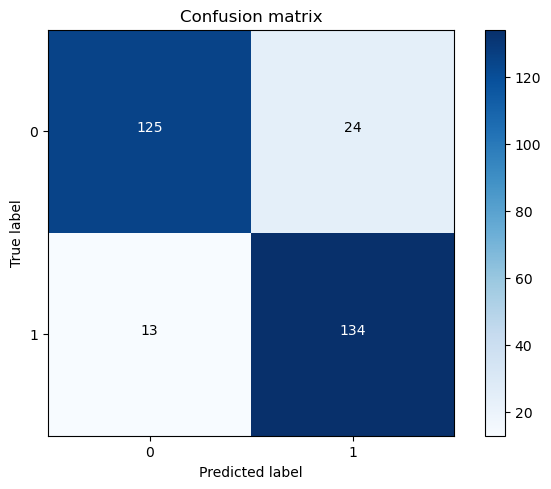

In [12]:
import itertools
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')#引入这孩子齐纳得出的最佳c参数
lr.fit(X_train_undersample,y_train_undersample.values.ravel())#使用最好的模型对训练集进行训练
y_pred_undersample = lr.predict(X_test_undersample.values)#用测试集预测模型结果

cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)#计算混淆矩阵所需值
np.set_printoptions(precision=2)#精度为小数点后2位

print("测试集中的召回率: ",cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

#绘图
class_names = [0,1]
plt.figure()#画图前先设置画布
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

上述结果解释：这是理想情况下的测试，因为下采样数据集中正常样本：异常样本=1：1，但实际数据是28w：500。

用原始数据的测试集测试下采样方案

测试集中的召回率:  0.8954248366013072


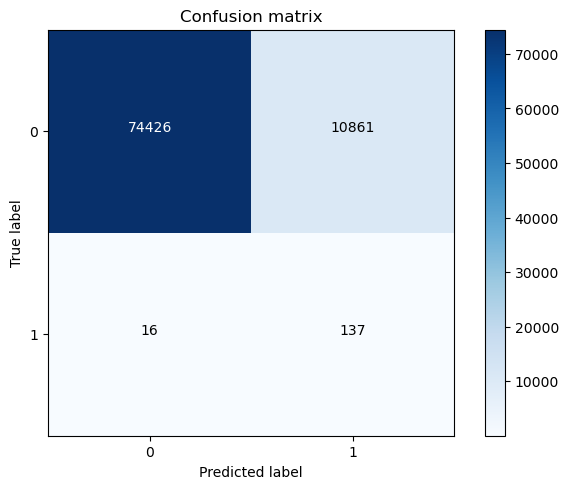

In [13]:
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)#这里将下采样测试集换为实际情况的测试集

#计算混淆矩阵所需值
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("测试集中的召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

#绘图
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

上述结果解释：这是实际情况下的测试，可以看出——在数据量小的数据集上训练出的模型应用在数据量大的数据集上，召回率偏差不大，但实际为正常数据而被预测为异常数据的数据量占比偏高，即假阳性太多。

**4.下采样方案训练模型改进**

**4.1.不采样方案训练模型**

如果一开始没有对数据进行预处理，结果怎样。

In [14]:
best_c = printing_Kfold_scores(X_train,y_train)#传入原始数据集

-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------

Iteration  1 : 召回率=  0.45454545454545453
Iteration  2 : 召回率=  0.5909090909090909
Iteration  3 : 召回率=  0.6268656716417911
Iteration  4 : 召回率=  0.5
Iteration  5 : 召回率=  0.53125

平均召回率:  0.5407140434192673

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------

Iteration  1 : 召回率=  0.5757575757575758
Iteration  2 : 召回率=  0.6666666666666666
Iteration  3 : 召回率=  0.6865671641791045
Iteration  4 : 召回率=  0.5526315789473685
Iteration  5 : 召回率=  0.53125

平均召回率:  0.602574597110143

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------

Iteration  1 : 召回率=  0.5909090909090909
Iteration  2 : 召回率=  0.6818181818181818
Iteration  3 : 召回率=  0.6417910447761194
Iteration  4 : 召回率=  0.5789473684210527
Iteration  5 : 召回率=  0.546875

平均召回率:  0.608068137184889

-------------------------------------------
正则化惩罚力度: 

可以看出，由于原始数据严重不平衡，召回效果不平衡，召回效果比较差。因此对数据进行预处理是很有必要的。

通过混淆矩阵来查看原始数据训练模型的预测结果

测试集中的召回率:  0.5816993464052288


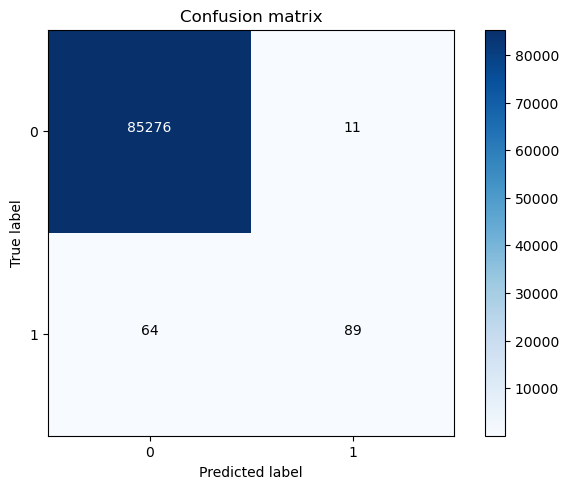

In [15]:
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

#计算混淆矩阵所需值
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("测试集中的召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

#绘图
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

上述结果解释：观察混淆矩阵可以看出，如果使用原始数据训练模型，预测结果——假阳性变少，但是对应的召回率较低，很多欺诈数据没有找到。

**4.2.调整下采样阈值并训练模型**

之前我们使用的是默认阈值0.5，如果自己指定阈值，结果怎样。

测试集中的召回率:  1.0
测试集中的召回率:  1.0
测试集中的召回率:  1.0
测试集中的召回率:  0.9727891156462585
测试集中的召回率:  0.9115646258503401
测试集中的召回率:  0.8775510204081632
测试集中的召回率:  0.8163265306122449
测试集中的召回率:  0.7687074829931972
测试集中的召回率:  0.5850340136054422


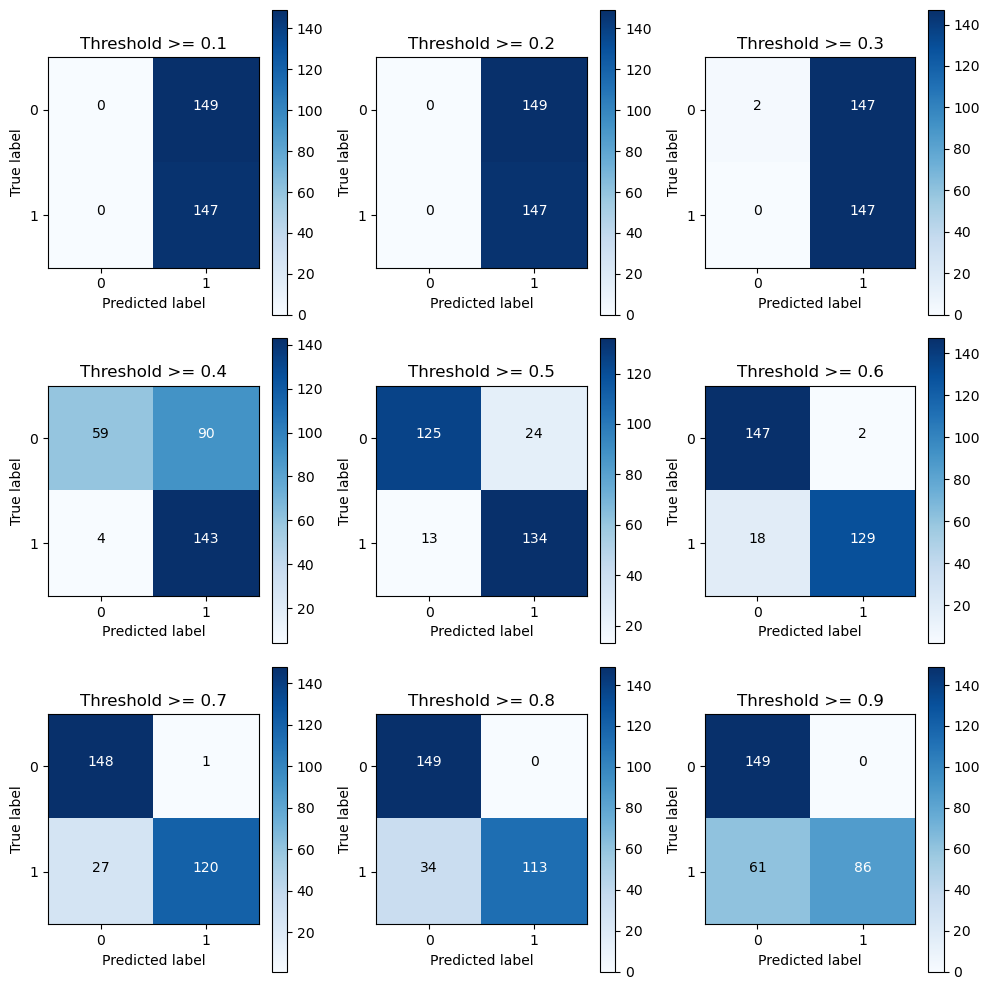

In [16]:
lr = LogisticRegression(C = 0.01, penalty = 'l1',solver='liblinear')#用下采样数据集得到的最好参数建模
lr.fit(X_train_undersample,y_train_undersample.values.ravel())#还用下采样数据集训练模型
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)#利用predict_proba得到预测结果的概率值

#设置不同的阈值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))#设置画布大小

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i#将概率值转化：判断（以0.5为例）。概率值比0.5大是异常；比0.5小是正常
    
    plt.subplot(3,3,j)#3*3的子图，j表示几个图，每张图对应一个阈值
    j += 1#设置子图起点
    
    #计算混淆矩阵所需值
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("测试集中的召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    
    #绘图
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

上述结果解释：随着阈值增大，召回率降低，因为判断异常的标准提高了。当阈值为0.1-0.3时，召回率为1，但是将所有样本当作异常，这样的模型没有意义；当阈值为0.4时，召回率高但是假阳性太高，不用；当阈值为0.6时，对比0.5，漏检变多，假阳性变少，具体选哪一个要看实际指标；当阈值为0.7-0.9时，召回率低，模型不不可取。

最终结论：下采样方案有局限性，假阳性高，下面采用过采样方案。

**5.过采样方案训练模型**

**5.1建立过采样训练集、测试集**

过采样方案如何生成数据：SMOTE样本生成策略——在两个样本连线上随机生成新样本。<br/>
步骤：1.判断哪部分是少数数据。2.计算样本间距离。3.将样本距离从小到大排序。4.确定一个倍率k=i，选最小的i个距离的d，5.x_new=x+Random(0,1)*d。

导入工具包

In [17]:
import pandas as pd 
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

读取数据，划分特征和标签

In [18]:
credit_cards=pd.read_csv('./data/data_creditcard.csv',encoding='gbk')#读取数据

columns=credit_cards.columns#获取表中的列名
features_columns=columns.delete(len(columns)-1)#删除最后一列（类别列）

features=credit_cards[features_columns]#获取除“类别”列以外的所有特征
labels=credit_cards['类别']#获取“类别”列的标签

数据集切分：将数据集且分为训练集和测试集

In [19]:
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.2, 
                                                                            random_state=0)

基于SMOTE算法进行样本生成，创造新的数据集，这样正例和负例样本数量就一致了

In [20]:
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_resample(features_train,labels_train)

查看训练集样本数据，标签为0和1的数据1:1，均为227450个

In [21]:
len(os_labels[os_labels==1])

227450

**5.2.训练模型**

利用新的过采样数据集进行交叉验证，找到best_c

In [22]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)
best_c = printing_Kfold_scores(os_features,os_labels)

-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------

Iteration  1 : 召回率=  0.8831168831168831
Iteration  2 : 召回率=  0.93125
Iteration  3 : 召回率=  0.9650256773508057
Iteration  4 : 召回率=  0.9588261156298088
Iteration  5 : 召回率=  0.958727192789624

平均召回率:  0.9393891737774244

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------

Iteration  1 : 召回率=  0.8831168831168831
Iteration  2 : 召回率=  0.93125
Iteration  3 : 召回率=  0.9663095448910927
Iteration  4 : 召回率=  0.9596504726313475
Iteration  5 : 召回率=  0.9598373268850297

平均召回率:  0.9400328455048707

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------

Iteration  1 : 召回率=  0.8831168831168831
Iteration  2 : 召回率=  0.93125
Iteration  3 : 召回率=  0.9665309013635559
Iteration  4 : 召回率=  0.958540338535942
Iteration  5 : 召回率=  0.9584633985491317

平均召回率:  0.9395803043131027

----------------------------------------

**5.3.测试模型**

利用混淆矩阵查看模型结果

测试集中的召回率:  0.8761904761904762


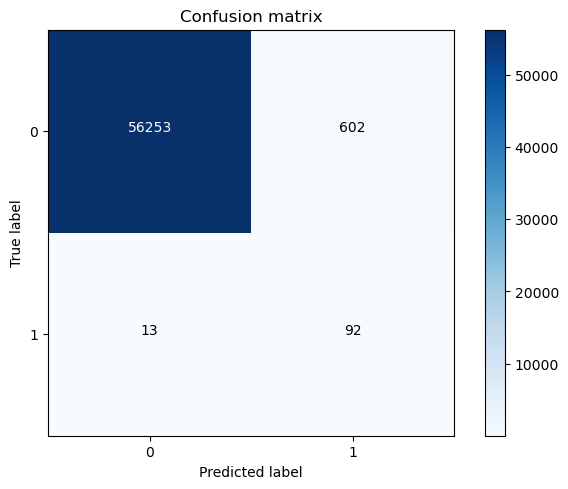

In [23]:
lr = LogisticRegression(C = best_c, penalty = 'l1',solver='liblinear')
lr.fit(os_features,os_labels.values.ravel())
y_pred = lr.predict(features_test.values)

#计算混淆矩阵所需值
cnf_matrix = confusion_matrix(labels_test,y_pred)
np.set_printoptions(precision=2)

print("测试集中的召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

#绘制
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

上述结果解释：观察混淆矩阵，与下采样方案相比，召回率略低，但将正常样本误判为异常样本的数目明显减少，故过采样策略模型效果更好。